In [1]:
import re
import string
from typing import List
from copy import deepcopy
from itertools import chain

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import spacy
from spacy.training.iob_utils import biluo_to_iob, doc_to_biluo_tags
from nltk.corpus import stopwords
from nltk import tokenize

import torch

%matplotlib inline

In [2]:
from tqdm import tqdm

tqdm.pandas()

In [3]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


# Utils

All the functions bellow are for text cleaning

In [4]:
def get_locations(row, with_text=False):
    text, locs = row[0], row[1]
    locs = [text[loc[0]:loc[1]] for loc in locs]
    return (text, locs) if with_text else locs

In [5]:
def remove_unbalanced_brackets(text):
    # Remove unopened or unclosed brackets
    while '(' in text and ')' not in text[text.index('('):]:
        text = text.replace('(', '', 1)
    while ')' in text and '(' not in text[:text.rindex(')')]:
        text = text[:text.rindex(')')] + text[text.rindex(')') + 1:]
    return text


In [6]:
def preprocess_text(text):
    # Your existing preprocessing steps
    text = re.sub(r'http\S+|www.\S+', '', text)
    phone_regex = r'\(?\+?\d{0,3}\)?[-.\s]?\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{2}[-.\s]?\d{2}'
    text = re.sub(phone_regex, '', text)

    chars_to_remove = ('+;°#̂,ี¡”\x03ֹ≠้‑".‘ા·:⁉*->˗’√Ⓑ\u202c§ื}¿؛⏺≈̀|∩„\xad¸®¬ิ¦;“¥–€̆ึ⋅Ⓔ\u202d≥→←҆¯'
                       '⏳̶™…©»№\x9d℃\x96\x08?«็−ุ،‰~ู̧∆‼•\\^¨\u2060᾿ְ※<₽\x7f\u200f่[\x04]⃣\x0f\xa0'
                       '⏰\u200c%±″†(÷′Ⓕ́ु$՚`/\'∙{ा)₴£\u202aั⁾≡×&¤⊕↓⁽\x97̈؟\x98๊≤@↑˚ો્´!›‚∞‛\u200b\x01')
    text = re.sub('[' + re.escape(chars_to_remove) + ']', '', text)

    text = re.sub(r'[\n\t]', ' ', text)
    text = re.sub(r'@\w+', '', text)
    pattern = r"(?:https?:\/\/)?(?:www\.)?(?:t\.me\/\S+|telegram\.me\/\S+|telegram\.dog\/\S+)"
    text = re.sub(pattern, '', text)
    emoji_pattern = re.compile(
        pattern="["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                "]+", flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text)
    text = re.sub(r' +', ' ', text)
    text = remove_unbalanced_brackets(text)

    return text

In [7]:
def update_locations(row, text_processor):
    text, locations = row
    location_texts = get_locations((text, locations))
    text = text_processor(text)

    new_locations = []
    offset = 0
    for loc_text in location_texts:
        clean_loc_text = text_processor(loc_text)
        start_idx = text.find(clean_loc_text, offset)
        if start_idx != -1:
            end_idx = start_idx + len(clean_loc_text)
            new_locations.append((start_idx, end_idx))
            offset = end_idx

    return text, new_locations

In [8]:
def clean_text_and_locations(row, text_processor=preprocess_text):
    index = 0
    text, locations = update_locations(row, text_processor)
    result: list[tuple[int, int]] = []

    while True:
        if index >= len(locations):
            break

        location = locations[index]
        location_text = text[location[0]:location[1]]
        try:
            if location_text.startswith('-'):
                if len(location_text) > 1:
                    result[-1] = (result[-1][0], location[1])
                else:
                    result[-1] = (result[-1][0], locations[index + 1][1])
                    index += 1
            elif location_text.endswith(('.', '. ', '—', '— ')):
                if location_text != '.' and location_text != 'вул.':
                    new_end = location_text.rfind('.')
                    new_end = len(location_text[:new_end].strip())
                    result.append((location[0], location[0] + new_end))
            elif ' і ' in location_text:
                loc1, loc2 = location_text.split(' і ')
                result.extend(
                    [
                        (location[0], location[0] + len(loc1)),
                        (location[1] - len(loc2), location[1])
                    ]
                )
            else:
                result.append(location)
        except Exception:
            pass

        index += 1
    return text, result

# Preprocess 
## UA dataset

Loading data

In [9]:
uk_geo_dataset = pd.read_csv('Data/uk_geo_dataset.csv', converters={"loc_markers": eval})
uk_geo_dataset.shape

(1010000, 5)

Removing unused columns

In [10]:
uk_geo_dataset = uk_geo_dataset.drop(columns=['org_markers', 'per_markers'])

Use functions above to clean text and locations

In [11]:
cleaned_uk = uk_geo_dataset[['text', 'loc_markers']].apply(clean_text_and_locations, axis=1)
cleaned_uk = list(zip(*cleaned_uk))
cleaned_uk = pd.DataFrame({'clean_text': cleaned_uk[0], 'clean_loc_markers': cleaned_uk[1]})
cleaned_uk.shape

(1010000, 2)

In [12]:
uk_geo_df = pd.concat([uk_geo_dataset, cleaned_uk], axis=1)
uk_geo_df.head()

,text,loc_markers,is_valid,clean_text,clean_loc_markers
0,"Чим довше мають скачки тиску гіпертензією, тим...",[],0,Чим довше мають скачки тиску гіпертензією тим ...,[]
1,"А поки що починали цвісти троянди, випускники ...",[],0,А поки що починали цвісти троянди випускники с...,[]
2,"Крім того, в 2020 р. багато експертів прогнозу...",[],0,Крім того в 2020 р багато експертів прогнозуют...,[]
3,"Сильно сумніваюся, що ви зупините свій вибір н...",[],0,Сильно сумніваюся що ви зупините свій вибір на...,[]
4,Цей унікальний правовий важіль утворено 1998 р...,[],0,Цей унікальний правовий важіль утворено 1998 р...,[]


Build additional features:
  - `language`: shows from what dataset this row
  - `number_of_locations`: represents number of locations in this text
  - `stratify_col`: as previous, but texts with too many locations are grouped together

In [13]:
uk_geo_df['language'] = 'ua'

uk_geo_df["number_of_locations"] = uk_geo_df["clean_loc_markers"].parallel_apply(len)

uk_geo_df["stratify_col"] = uk_geo_df["number_of_locations"]
uk_geo_df.loc[uk_geo_df["number_of_locations"] >= 14, "stratify_col"] = -1

uk_geo_df.head()

,text,loc_markers,is_valid,clean_text,clean_loc_markers,language,number_of_locations,stratify_col
0,"Чим довше мають скачки тиску гіпертензією, тим...",[],0,Чим довше мають скачки тиску гіпертензією тим ...,[],ua,0,0
1,"А поки що починали цвісти троянди, випускники ...",[],0,А поки що починали цвісти троянди випускники с...,[],ua,0,0
2,"Крім того, в 2020 р. багато експертів прогнозу...",[],0,Крім того в 2020 р багато експертів прогнозуют...,[],ua,0,0
3,"Сильно сумніваюся, що ви зупините свій вибір н...",[],0,Сильно сумніваюся що ви зупините свій вибір на...,[],ua,0,0
4,Цей унікальний правовий важіль утворено 1998 р...,[],0,Цей унікальний правовий важіль утворено 1998 р...,[],ua,0,0


## RU dataset

Loading dataset

In [14]:
ru_geo_dataset = pd.read_csv('Data/ru_geo_dataset.csv')

In [15]:
ru_geo_dataset['loc_markers'] = ru_geo_dataset['loc_markers'].parallel_apply(eval)

Grouping it by `doc_id`

In [16]:
docs_groups = ru_geo_dataset.groupby('doc_id')

In [17]:
del ru_geo_dataset

In [18]:
def merge_groups(group, text_only=True):
    group = group.sort_values(by=['sent_id']).reset_index(drop=True)
    if text_only:
        return ' '.join(group['text'])
    else:
        try:
            offset = 0
            new_locs = group.loc[0, 'loc_markers']
            for sentence, locs in zip(group['text'].tolist()[:-1], group['loc_markers'].tolist()[1:]):
                offset += len(sentence)
                for loc in locs:
                    new_locs.append((loc[0] + offset, loc[1] + offset))
        except Exception:
            print(group)
        return {'text': ' '.join(group['text']), 'loc_markers': new_locs}

Concatenate together text from one document

In [19]:
grouped_ru_df = docs_groups.apply(merge_groups, text_only=False)
grouped_ru_df = pd.DataFrame(
    {
        'text': [row['text'] for row in grouped_ru_df],
        'loc_markers': [row['loc_markers'] for row in grouped_ru_df]
    }
)
grouped_ru_df

,text,loc_markers
0,Вице-премьер по социальным вопросам Татьяна Го...,"[(82, 88), (250, 259), (261, 269), (271, 279),..."
1,Австрийские правоохранительные органы не предс...,"[(0, 11), (147, 153), (156, 160), (580, 586), ..."
2,Сотрудники социальной сети Instagram проанализ...,"[(256, 266), (269, 274), (388, 399), (945, 953)]"
3,С начала расследования российского вмешательст...,"[(65, 68), (182, 185), (450, 453), (662, 665),..."
4,Хакерская группировка Anonymous опубликовала н...,"[(382, 396), (505, 510), (551, 572), (636, 641..."
...,...,...
739185,Сегодня областной центр Сахалина и Курил получ...,"[(24, 32), (35, 40), (148, 167), (192, 207), (..."
739186,Выступая сегодня на пресс-конференции в Москве...,"[(40, 46)]"
739187,Сегодня утром в районах дагестанских селений Ч...,"[(45, 54), (57, 65), (228, 230), (233, 242), (..."
739188,Намеченная на сегодняшний день церемония вступ...,"[(146, 152), (311, 317), (363, 381), (447, 465..."


Clean result texts

In [20]:
cleaned_group_ru = grouped_ru_df[['text', 'loc_markers']].apply(clean_text_and_locations, axis=1)
cleaned_group_ru = list(zip(*cleaned_group_ru))
cleaned_group_ru = pd.DataFrame({'clean_text': cleaned_group_ru[0], 'clean_loc_markers': cleaned_group_ru[1]})
cleaned_group_ru.shape

(739190, 2)

In [21]:
ru_geo_docs_df = pd.concat([grouped_ru_df, cleaned_group_ru], axis=1).reset_index(drop=True)
ru_geo_docs_df.head()

,text,loc_markers,clean_text,clean_loc_markers
0,Вице-премьер по социальным вопросам Татьяна Го...,"[(82, 88), (250, 259), (261, 269), (271, 279),...",Вицепремьер по социальным вопросам Татьяна Гол...,"[(80, 86), (245, 254), (255, 263), (264, 272),..."
1,Австрийские правоохранительные органы не предс...,"[(0, 11), (147, 153), (156, 160), (580, 586), ...",Австрийские правоохранительные органы не предс...,"[(0, 11), (146, 152), (155, 159), (567, 573), ..."
2,Сотрудники социальной сети Instagram проанализ...,"[(256, 266), (269, 274), (388, 399), (945, 953)]",Сотрудники социальной сети Instagram проанализ...,"[(252, 262), (265, 270), (383, 394), (924, 932)]"
3,С начала расследования российского вмешательст...,"[(65, 68), (182, 185), (450, 453), (662, 665),...",С начала расследования российского вмешательст...,"[(65, 68), (181, 184), (443, 446), (653, 656),..."
4,Хакерская группировка Anonymous опубликовала н...,"[(382, 396), (505, 510), (551, 572), (636, 641...",Хакерская группировка Anonymous опубликовала н...,"[(377, 391), (498, 503), (542, 563), (625, 630..."


As above, add some extra features:
  - `language`: shows from what dataset this row
  - `number_of_locations`: represents number of locations in this text
  - `stratify_col`: as previous, but texts with too many locations are grouped together

In [22]:
ru_geo_docs_df['language'] = 'ru'

ru_geo_docs_df['number_of_locations'] = ru_geo_docs_df['clean_loc_markers'].parallel_apply(len)

ru_geo_docs_df["stratify_col"] = ru_geo_docs_df["number_of_locations"]
ru_geo_docs_df.loc[ru_geo_docs_df["number_of_locations"] >= 14, "stratify_col"] = -1

ru_geo_docs_df.head()

,text,loc_markers,clean_text,clean_loc_markers,language,number_of_locations,stratify_col
0,Вице-премьер по социальным вопросам Татьяна Го...,"[(82, 88), (250, 259), (261, 269), (271, 279),...",Вицепремьер по социальным вопросам Татьяна Гол...,"[(80, 86), (245, 254), (255, 263), (264, 272),...",ru,7,7
1,Австрийские правоохранительные органы не предс...,"[(0, 11), (147, 153), (156, 160), (580, 586), ...",Австрийские правоохранительные органы не предс...,"[(0, 11), (146, 152), (155, 159), (567, 573), ...",ru,7,7
2,Сотрудники социальной сети Instagram проанализ...,"[(256, 266), (269, 274), (388, 399), (945, 953)]",Сотрудники социальной сети Instagram проанализ...,"[(252, 262), (265, 270), (383, 394), (924, 932)]",ru,4,4
3,С начала расследования российского вмешательст...,"[(65, 68), (182, 185), (450, 453), (662, 665),...",С начала расследования российского вмешательст...,"[(65, 68), (181, 184), (443, 446), (653, 656),...",ru,10,10
4,Хакерская группировка Anonymous опубликовала н...,"[(382, 396), (505, 510), (551, 572), (636, 641...",Хакерская группировка Anonymous опубликовала н...,"[(377, 391), (498, 503), (542, 563), (625, 630...",ru,13,13


# Explore distributions

Add column with text length, because we want to explore its distributions

In [23]:
nlp = spacy.blank('xx')
uk_geo_df['text_lengths'] = uk_geo_df['clean_text'].apply(lambda x: len(nlp(x)))
ru_geo_docs_df['text_lengths'] = ru_geo_docs_df['clean_text'].apply(lambda x: len(nlp(x)))

## Test distributions

In [24]:
test_df = pd.read_csv('Data/test.csv')
test_df.head()

,text_id,text,locations
0,0,"❗️Кількість поранених зросла до трьох, – Кличк...",[]
1,1,"🥤В Києві за 91,13 млн гривень починаються робо...",[]
2,2,▪️Сьогодні вночі росіяни завдали ракетного уда...,[]
3,3,Наразі у запасах росіян найбільше балістичних ...,[]
4,4,"⛸В один день, 29 серпня, ДП ""Центральна учбово...",[]


In [25]:
test_df['clean_text'] = test_df['text'].apply(preprocess_text)
test_df['text_lengths'] = test_df['clean_text'].apply(lambda x: len(nlp(x)))

Build text distribution in test data

<Axes: xlabel='text_lengths', ylabel='Probability'>

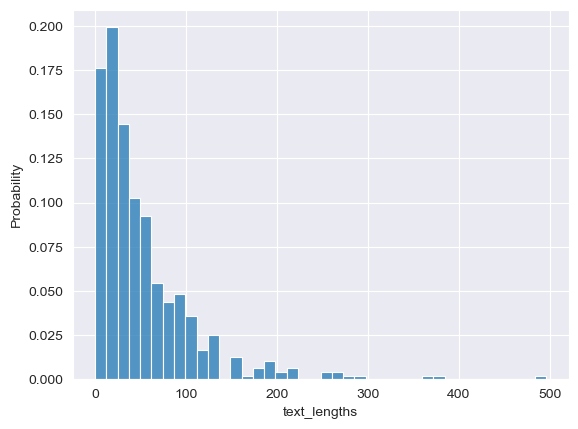

In [26]:
sns.histplot(test_df, x='text_lengths', bins=40, stat='probability')

## UA texts

<Axes: xlabel='text_lengths', ylabel='Count'>

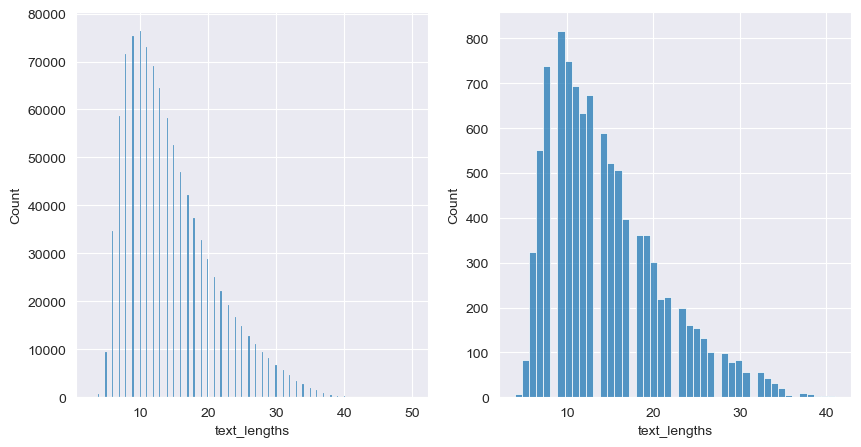

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(uk_geo_df[uk_geo_df['is_valid'] == 0], x='text_lengths', ax=axes[0])
sns.histplot(uk_geo_df[uk_geo_df['is_valid'] == 1], x='text_lengths', ax=axes[1])

As we see above, train and validation texts have same length distribution. But when we compare this to the distribution of the test set, we can observe that the maximum text length of UA texts is 40. In contrast, within the test data, there are texts with lengths exceeding 500.

Below we can see that `stratify_col` has same distribution in train and validation sets

<Axes: xlabel='stratify_col', ylabel='Count'>

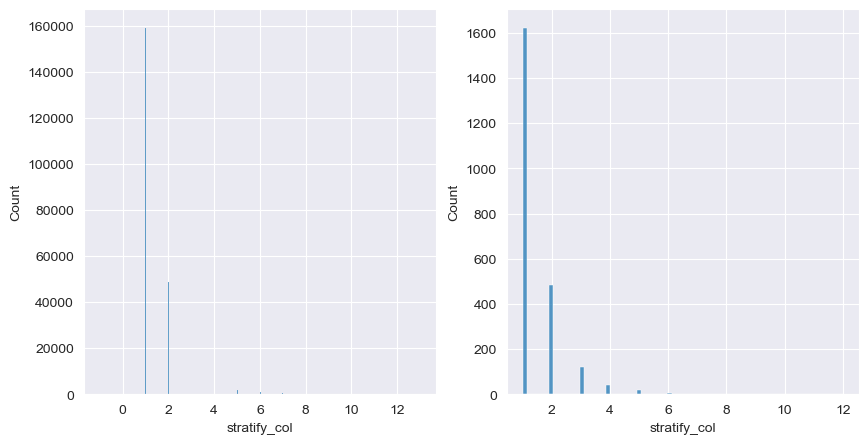

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

mask = (uk_geo_df['number_of_locations'] > 0) & (uk_geo_df['is_valid'] == 0)
sns.histplot(uk_geo_df[mask], x='stratify_col', ax=axes[0])

mask = (uk_geo_df['number_of_locations'] > 0) & (uk_geo_df['is_valid'] == 1)
sns.histplot(uk_geo_df[mask], x='stratify_col', ax=axes[1])

## RU texts

Firstly, we see that in RU dataset there are some too long texts, even longer than test one. Obviously they are outsiders. Therefore, it was decided to remove them.

<Axes: xlabel='text_lengths', ylabel='Count'>

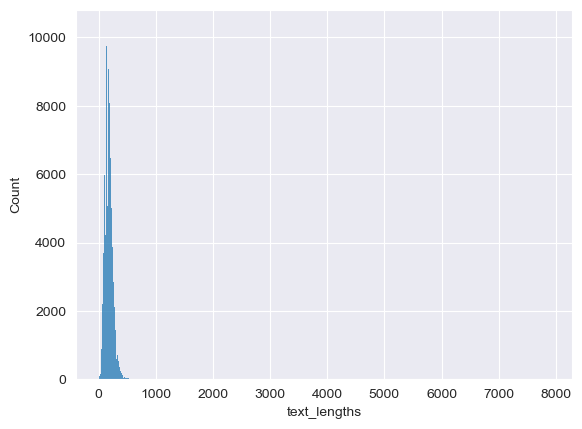

In [29]:
sns.histplot(ru_geo_docs_df, x='text_lengths')

Now, if we observe the text lengths, we can notice that they follow an almost normal distribution with a mean of approximately 160. The majority of the data falls within the range of 100 to 300. 

<Axes: xlabel='text_lengths', ylabel='Count'>

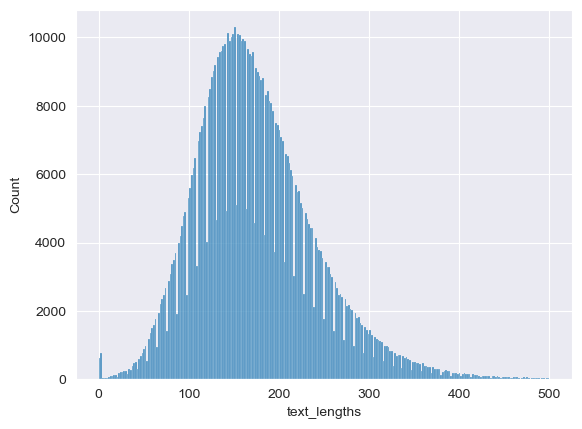

In [30]:
ru_geo_docs_df = ru_geo_docs_df[ru_geo_docs_df['text_lengths'] <= 500]
sns.histplot(ru_geo_docs_df[ru_geo_docs_df['text_lengths'] <= 500], x='text_lengths')

<Axes: xlabel='stratify_col', ylabel='Count'>

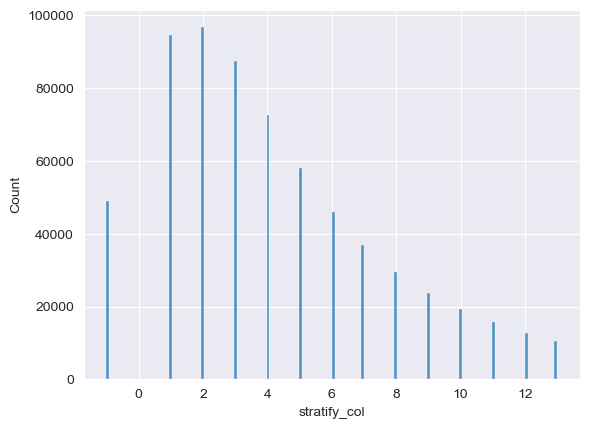

In [31]:
mask = (ru_geo_docs_df['number_of_locations'] > 0)
sns.histplot(ru_geo_docs_df[mask], x='stratify_col')

## Merged UA and RU

In [32]:
df = pd.concat([uk_geo_df, ru_geo_docs_df])
df.head()

,text,loc_markers,is_valid,clean_text,clean_loc_markers,language,number_of_locations,stratify_col,text_lengths
0,"Чим довше мають скачки тиску гіпертензією, тим...",[],0.0,Чим довше мають скачки тиску гіпертензією тим ...,[],ua,0,0,12
1,"А поки що починали цвісти троянди, випускники ...",[],0.0,А поки що починали цвісти троянди випускники с...,[],ua,0,0,24
2,"Крім того, в 2020 р. багато експертів прогнозу...",[],0.0,Крім того в 2020 р багато експертів прогнозуют...,[],ua,0,0,21
3,"Сильно сумніваюся, що ви зупините свій вибір н...",[],0.0,Сильно сумніваюся що ви зупините свій вибір на...,[],ua,0,0,10
4,Цей унікальний правовий важіль утворено 1998 р...,[],0.0,Цей унікальний правовий важіль утворено 1998 р...,[],ua,0,0,9


<Axes: xlabel='text_lengths', ylabel='Count'>

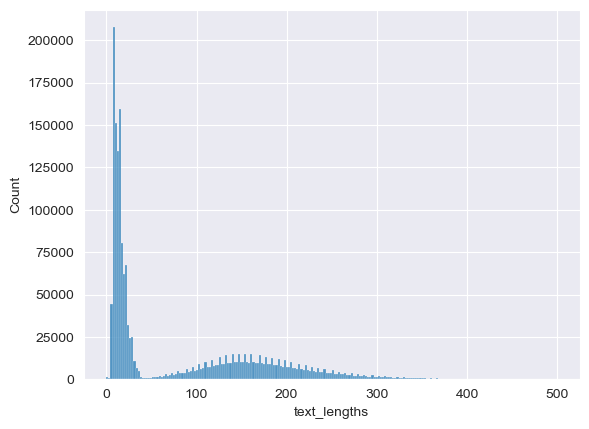

In [33]:
sns.histplot(df, x='text_lengths')

By comparing this to the UA, RU dataset and the test dataset, we can make an assumption that in the test dataset, texts with a length less than 40 are likely to be Ukrainian, while texts with a length greater than 40 are likely to be Russian.

<Axes: xlabel='stratify_col', ylabel='Count'>

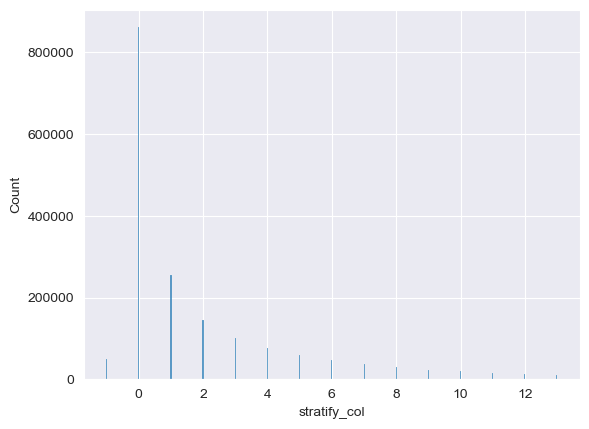

In [34]:
sns.histplot(df, x='stratify_col')

# Build labeling

The below code is copied from lecture. This code make labels and tokenized text.

In [35]:
text_col = 'clean_text'
loc_col = 'clean_loc_markers'

In [36]:
df[loc_col+'_'] = df[loc_col].parallel_apply(lambda x: [[y[0], y[1], 'LOC'] for y in x])

In [37]:
def convert_to_conll(row):
    data = {
        "text": row[text_col],
        "label": row[loc_col + '_']
    }
    doc = nlp(data["text"])
    ents = []
    for start, end, label in data["label"]:
        span = doc.char_span(start, end, label=label)
        if span is not None:
            ents.append(span)
        else:
            pass

    doc.ents = ents
    return {
        'tokens': list([t.text for t in doc]),
        'labels': list(biluo_to_iob(doc_to_biluo_tags(doc)))
    }

Personally, I cannot figure out how to deal with skipping spans. I have noticed that most of them are in Russian text, but there are too many different types of poorly labeled data for me to imagine how to work with them. My only option is to skip or relabel them.

In [38]:
df['conll'] = df.progress_apply(convert_to_conll, axis=1)

100%|██████████| 1747433/1747433 [07:58<00:00, 3654.50it/s] 


In [39]:
df['conll'].isna().mean()

0.0

In [40]:
label2id = {'O': 0, 'B-LOC': 1, 'I-LOC': 2}

df['tokens'] = df.conll.str['tokens']
df['ner_tags'] = df.conll.str['labels'].apply(lambda x: [label2id[t] for t in x])

# Make validation

Below, are presented two types of splitting merged dataset on train/validation sets.
First one takes all validation data from UA dataset (marked as 'is_valid' == 1) and add some rows from RU dataset to make final validation dataset has the same or almost same text lengths distributions as in test data.
Second type make final validation dataset has the same text lengths distributions as in test data even if we drop some samples from UA validation data ('is_valid' == 1).

## First type

In [41]:
def balance_dfs_added(df1, df2, df3, column_name):
    # Calculate the target distribution from df3
    target_distribution = df3[column_name].value_counts(normalize=True)

    # Initialize an empty dataframe to store the new rows
    new_rows = pd.DataFrame(columns=['text', column_name])

    # For each unique text_length in df1
    for length in df1[column_name].unique():
        # If this text_length exists in the target distribution
        if length in target_distribution.index:
            # Calculate how many rows we need to add to match the target distribution
            num_rows_to_add = int(target_distribution[length] * len(df2) - df2[df2[column_name] == length].shape[0])

            # If we need to add rows
            if num_rows_to_add > 0:
                # Get all rows from df1 with this text_length
                available_rows = df1[df1[column_name] == length]

                # Randomly sample the required number of rows
                sampled_rows = available_rows.sample(n=num_rows_to_add, replace=True)

                # Add the sampled rows to our new_rows dataframe
                new_rows = pd.concat([new_rows, sampled_rows])

    # Add the new rows to df2 and return the result
    return pd.concat([df2, new_rows])

In [42]:
valid_sample = balance_dfs_added(df[df['language'] == 'ru'], df[df['is_valid'] == 1], test_df, 'text_lengths')

<Axes: xlabel='text_lengths', ylabel='Probability'>

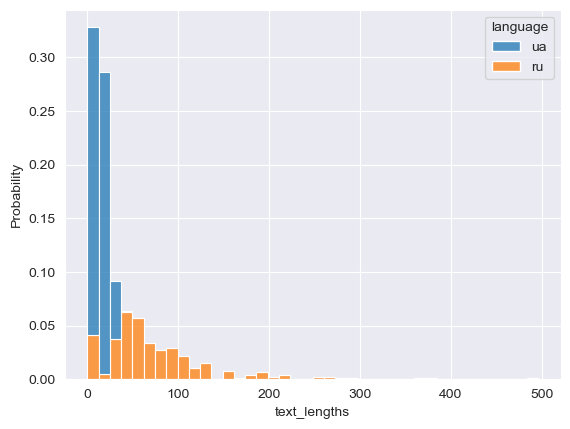

In [43]:
sns.histplot(valid_sample, x='text_lengths', bins=40, hue='language', stat='probability', multiple='stack')

In [44]:
valid_sample[valid_sample['language'] == 'ua']['is_valid'].value_counts()

is_valid
1.0    10000
Name: count, dtype: int64

In [45]:
valid_sample.shape[0] / df.shape[0]

0.009172883881671

## Second Type

In [46]:
def balance_dfs_exact(df1, df2, df3, column_name):
    # Calculate the target distribution from df3
    target_distribution = df3[column_name].value_counts(normalize=True)

    dist_df2 = df2[column_name].value_counts()

    # Initialize an empty dataframe to store the new rows
    new_rows = pd.DataFrame(columns=['text', column_name])

    # For each unique text_length in df1
    for length in df1[column_name].unique():
        # If this text_length exists in the target distribution
        if length in target_distribution.index:
            # Calculate how many rows we need to add to match the target distribution
            num_rows_to_add = int(target_distribution[length] * len(df2))
            if length in dist_df2.index:
                if dist_df2[length] >= num_rows_to_add:
                    available_rows = df2[df2[column_name] == length]
                    sampled_rows = available_rows.sample(n=num_rows_to_add, replace=True)
                else:
                    available_rows1 = df2[df2[column_name] == length]
                    available_rows2 = df1[df1[column_name] == length]
                    sampled_rows = available_rows2.sample(n=num_rows_to_add - dist_df2[length], replace=True)
                    sampled_rows = pd.concat([available_rows1, sampled_rows])
            else:
                available_rows = df1[df1[column_name] == length]
                sampled_rows = available_rows.sample(n=num_rows_to_add, replace=True)
            new_rows = pd.concat([new_rows, sampled_rows])

    # Add the new rows to df2 and return the result
    return new_rows

In [47]:
valid_sample = balance_dfs_exact(df[df['language'] == 'ru'], df[df['is_valid'] == 1], test_df, 'text_lengths')

<Axes: xlabel='text_lengths', ylabel='Probability'>

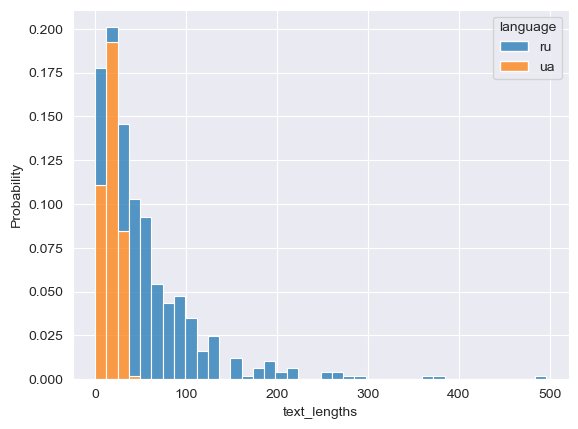

In [48]:
sns.histplot(valid_sample, x='text_lengths', bins=40, hue='language', stat='probability', multiple='stack')

In [49]:
valid_sample[valid_sample['language'] == 'ua']['is_valid'].value_counts()

is_valid
1.0    3845
Name: count, dtype: int64

In [50]:
valid_sample.shape[0] / df.shape[0]

0.0056505742995582664

## Final splitting

Finally was decided to make second type of validation dataset.

In [51]:
train = df[~df.index.isin(valid_sample.index)]
valid = df[df.index.isin(valid_sample.index)]

train['is_valid'] = 0
valid['is_valid'] = 1

df = pd.concat([train, valid])

C:\Users\Andrii\AppData\Local\Temp\ipykernel_29920\3597751843.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['is_valid'] = 0
C:\Users\Andrii\AppData\Local\Temp\ipykernel_29920\3597751843.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['is_valid'] = 1


In [52]:
df.shape

(1747433, 13)

In [53]:
train.shape, valid.shape

((1733496, 13), (13937, 13))

Finally, we save different sizes of datasets to have the opportunity to load different configurations while training the models.

In [54]:
train[['tokens', 'ner_tags']].to_json(
    './Data/transformers/train_processed.json', orient='records', lines=True
)
valid[['tokens', 'ner_tags']].to_json(
    './Data/transformers/valid_processed.json', orient='records', lines=True
)

MemoryError: 

In [55]:
train.sample(10000)[['tokens', 'ner_tags']].to_json(
    'Data/transformers/small_train_processed.json',
    orient='records', lines=True
    )
valid.sample(10000)[['tokens', 'ner_tags']].to_json(
    'Data/transformers/small_valid_processed.json',
    orient='records', lines=True
)

In [56]:
train.sample(100000)[['tokens', 'ner_tags']].to_json(
    'Data/transformers/medium_train_processed.json',
    orient='records', lines=True
)
valid[['tokens', 'ner_tags']].to_json(
    'Data/transformers/medium_valid_processed.json',
    orient='records', lines=True
)

In [57]:
train.sample(1000000)[['tokens', 'ner_tags']].to_json(
    'Data/transformers/big_train_processed.json',
    orient='records', lines=True
)
valid[['tokens', 'ner_tags']].to_json(
    'Data/transformers/big_valid_processed.json',
    orient='records', lines=True
)

In [58]:
df.to_csv('Data/data.csv', index=False)

train.to_csv('Data/data_train.csv', index=False)
valid.to_csv('Data/data_test.csv', index=False)

All modeling was done in second notebook in kaggle